In [149]:
import pandas as pd
import numpy as np
from datetime import datetime
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import cross_val_score
import string
import regex as re
from nltk.corpus import stopwords
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import emoji
from better_profanity import profanity

In [2]:
redits = pd.read_csv('./Data/scraped_clean_redits.csv')

In [3]:
redits.head()

,Title,Time,Comments,Subreddit
0,NaN,NaN,NaN,NaN
1,A random guy sends his vocals to deadmau5 - ge...,5 hours,526,r/Damnthatsinteresting
2,What is the craziest thing that's ever happene...,14 hours,7.1k,r/AskReddit
3,Woman is reunited with her dog that was missin...,6 hours,186,r/MadeMeSmile
4,[OC] saw this guy stealing a mirror in a parki...,6 hours,1.3k,r/pics


In [4]:
redits.columns = ['title', 'timestamp', 'comments', 'subreddit']


In [5]:
redits.dropna(inplace=True)

In [6]:
len(redits)

10160

## Converting the Time column isnto timestamp:

In [7]:
def convert_to_datetime(input):

    now = datetime.datetime.now()
    if 'minute' in input:
        number_of_minutes = int(input.split(' ')[0])                    
        time_posted = now - datetime.timedelta(minutes=number_of_minutes) 
        return time_posted
    
    elif 'hour' in input:
        number_of_hours = int(input.split(' ')[0])
        return now - datetime.timedelta(hours = number_of_hours)
    
    elif 'day' in input:
        number_of_days = int(input.split(' ')[0])
        return now - datetime.timedelta(days = number_of_days)
    
    elif 'month' in input:
        number_of_days = int(input.split(' ')[0])*30
        return now - datetime.timedelta(days=number_of_days)
    
    elif 'year' in input:
        number_of_days = int(input.split(' ')[0])*365
        return now - datetime.timedelta(days=number_of_days)
    
    elif 'just now' in input:
        return now - datetime.timedelta(hours= 15)
    
    else:
        return input

In [8]:
redits['timestamp'] = redits['timestamp'].apply(convert_to_datetime)

In [9]:
redits['timestamp'].head()

1   2022-09-06 18:29:56.668416
2   2022-09-06 09:29:56.668430
3   2022-09-06 17:29:56.668434
4   2022-09-06 17:29:56.668436
5   2022-09-06 09:29:56.668438
Name: timestamp, dtype: datetime64[ns]

## Converting the number of comments into integers:

In [10]:
def number_converter(each):
    if type(each) == float:
        return each
    else:
        if len(each) >5:
            return float(each.strip()[:2])
        else:
            each = each.strip()[:5]
        try:
            if 'm' in each:
                return float(each.strip('m').strip())*1_000_000
            elif 'k' in each:
                return float(each.strip('k').strip())*1_000
            else:
                return float(each)
        except:
            return None

In [11]:
redits['comments'] = redits['comments'].apply(number_converter)

In [12]:
redits['comments'].isnull().sum()

0

In [13]:
redits['comments'].dtypes

dtype('float64')

In [14]:
redits.head()

,title,timestamp,comments,subreddit
1,A random guy sends his vocals to deadmau5 - ge...,2022-09-06 18:29:56.668416,526.0,r/Damnthatsinteresting
2,What is the craziest thing that's ever happene...,2022-09-06 09:29:56.668430,7100.0,r/AskReddit
3,Woman is reunited with her dog that was missin...,2022-09-06 17:29:56.668434,186.0,r/MadeMeSmile
4,[OC] saw this guy stealing a mirror in a parki...,2022-09-06 17:29:56.668436,1300.0,r/pics
5,WCGW riding recklessly on the inter-state?,2022-09-06 09:29:56.668438,3900.0,r/Whatcouldgowrong


In [15]:
redits['title_length'] = redits['title'].apply(len)

In [16]:
redits['title_length'].median()

32.0

###  Checking the target column:

In [17]:
redits['comments'].mean()

269.66141732283467

# Establishing a baseline for a binary predictor:

In [18]:
redits['comments'].median()

9.0

Text(0.5, 1.0, 'baseline')

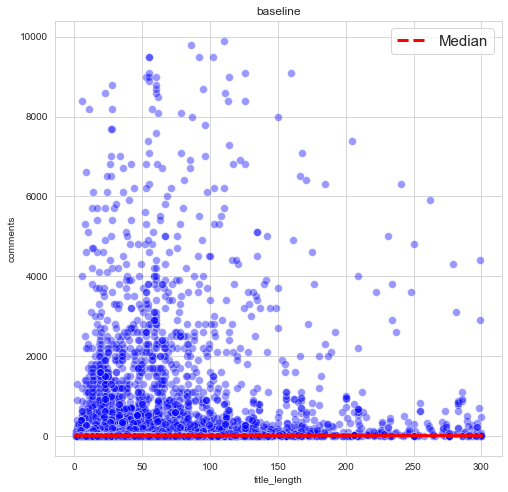

In [19]:
# Plotting the baseline:
plt.figure(figsize=(8,8))
y_mean = [np.median(redits['comments'])]*len(redits['title_length'])
sns.scatterplot(x =redits['title_length'],y = redits['comments'],color='blue',alpha=.4,s=60)
plt.plot(redits['title_length'],y_mean,label='Median', linestyle='--', color='red', linewidth=3)
plt.legend(fontsize=15);
plt.title('baseline')

## Exploring target distribution

In [20]:
# Adding high_enggement columns:
redits['high_engagement'] = redits['comments'].apply(lambda x: 1 if x > 9 else 0 )

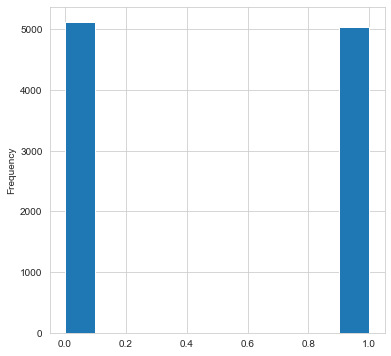

In [21]:
plt.figure(figsize=(6,6))
redits['high_engagement'].plot(kind='hist');

In [22]:
# Adding day_of_post column:
redits['day_of_post'] = redits['timestamp'].apply(lambda ts : ts.date().day)

In [23]:
# Adding month_of_post column:
redits['month_of_post'] = redits['timestamp'].apply(lambda ts : ts.date().month)

In [24]:
# Adding hour_of_post column:
redits['hour_of_post'] = redits['timestamp'].apply(lambda ts : ts.time().hour)

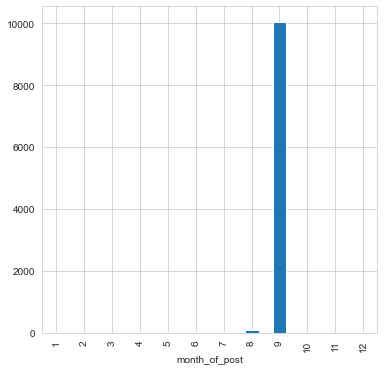

In [25]:
plt.figure(figsize=(6,6))
redits.groupby('month_of_post')['comments'].count().plot(kind='bar');

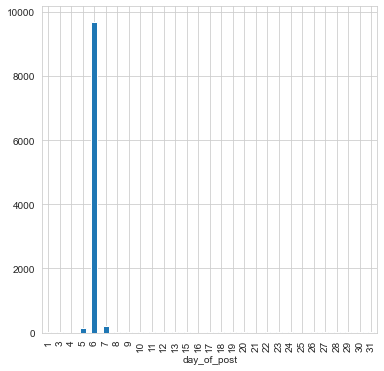

In [26]:
plt.figure(figsize=(6,6))
redits.groupby('day_of_post')['comments'].count().plot(kind='bar');

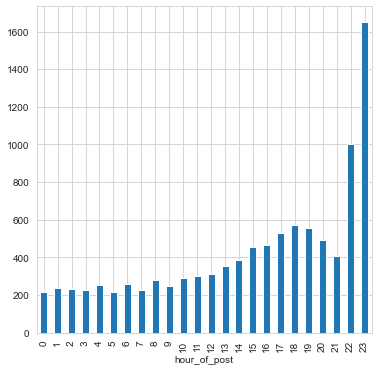

In [27]:
plt.figure(figsize=(6,6))
redits.groupby('hour_of_post')['comments'].count().plot(kind='bar');

## Observation:
> - Data is highly deviated in the `day_of_post` and `month_of_post`  because it was all collected in Auguest 31st, so in this case, I don't think it will be a good idea to consider the month of the post as a good predictor of the engagement 
> - I can see that `hour_of_post` still can be a **good predictor** of the interaction since it's less deviatedand kind of **following a patern**

In [28]:
# Dropping the month_of_post column:

redits.drop(columns=['month_of_post', 'day_of_post'], inplace=True)

In [29]:
# Removing all emojis:
def remove_emoji(string):
    return emoji.replace_emoji(string, replace='').strip()

redits['title'] = redits['title'].apply(remove_emoji)

# Converting all titles into lowercase:

redits['title'] = redits['title'].str.lower()

# Removing profanity:

redits['title'] = redits['title'].apply(lambda x: profanity.censor(x))

# Removing numbers from title:

redits['title'] = redits['title'].str.replace('\d+', '')

# Filter for strange characters:

redits['title'] = redits['title'].apply(lambda x: re.sub(r'\W+', ' ', x))

redits['title'] = redits['title'].apply(lambda x: re.sub(r"[^a-zA-Z0-9 ]", "", x))

/var/folders/b4/qnmj1swx0nx7h2b62nkjf05h0000gn/T/ipykernel_4187/89022224.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  redits['title'] = redits['title'].str.replace('\d+', '')


In [133]:
redits[['title']]

,title
1,a random guy sends his vocals to deadmau gets ...
2,what is the craziest thing that s ever happene...
3,woman is reunited with her dog that was missin...
4,oc saw this guy stealing a mirror in a parkin...
5,wcgw riding recklessly on the inter state
...,...
10156,my wife asked me what was the difference betwe...
10157,the uncut cooldown room footage
10158,why do you get hot when you stand in the corner
10159,what s your favorite pickup line


## Splitting the data:

In [145]:
X = redits['title']
y = redits['high_engagement']

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [147]:
def lemma_tokenizer(doc):
    wnl = WordNetLemmatizer()
    tokens = word_tokenize(doc)
    return [wnl.lemmatize(t) for t in tokens]

def stemmer_tokenizer(doc):
    ps = PorterStemmer()
    tokens = word_tokenize(doc)
    return [ps.stem(t) for t in tokens]

# Using Pipeline:

### - Predicting with Random forest

In [237]:
# Using CountVectorizer:


pipe = Pipeline([
    ('cv',CountVectorizer(tokenizer=lemma_tokenizer, max_df=250)),
    ('rfc', RandomForestClassifier(n_estimators=250))
])
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9772215973003374, 0.8323490813648294)

## Observation:
- Our Random Forest Model is performing with 83% accuracy which is a good improvement over the 50% class majority score

In [238]:
ft_imp_df = pd.DataFrame(pipe['rfc'].feature_importances_, 
             index=pipe['cv'].get_feature_names_out(),
             columns=['ft_imps'])

In [239]:
# Exploring the most important features contributing to high interaction messages:

ft_imp_df.sort_values(by='ft_imps', ascending=False).head(20)

,ft_imps
meme,0.004641
not,0.003703
oc,0.003085
being,0.003084
why,0.002955
everyone,0.002862
still,0.002860
no,0.002791
he,0.002766
ha,0.002703


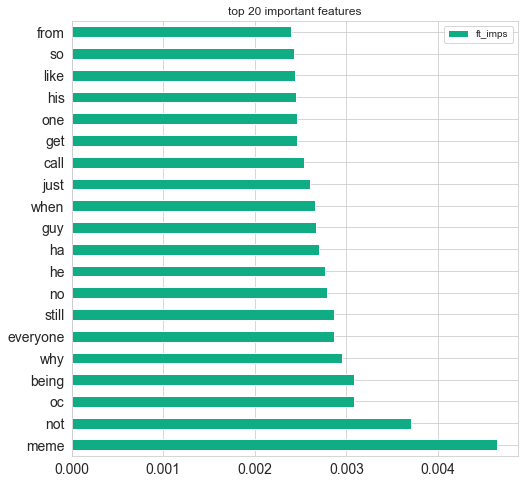

In [240]:
ft_imp_df.sort_values(by='ft_imps', ascending=False).head(20).plot(kind='barh',
                                                                    title = 'top 20 important features',
                                                                    figsize=(8,8), fontsize=14, color='#10ac84');

In [241]:
# Exploring some of the low importance words:
ft_imp_df[ft_imp_df['ft_imps']<.01].tail(100).index

Index(['wrote', 'wsb', 'wude', 'wvu', 'ww', 'www', 'wyspa', 'x', 'xbox',
       'xenoblade', 'xers', 'xi', 'xinzoruo', 'xl', 'xmas', 'xolaani', 'xp',
       'xponentialdesign', 'xqc', 'xsb', 'xvb', 'y', 'ya', 'yada', 'yakuza',
       'yall', 'yamato', 'yankee', 'yankovich', 'yazlar', 'ye', 'yea', 'yeah',
       'year', 'yearly', 'yeat', 'yeh', 'yeji', 'yelich', 'yell', 'yellow',
       'yep', 'yes', 'yesterday', 'yet', 'yiga', 'yk', 'yo', 'yodeling',
       'yoga', 'yolo', 'york', 'yosemite', 'yoshino', 'young', 'younger',
       'younglings', 'your', 'yourself', 'youthful', 'youtube', 'youtuber',
       'youtubers', 'youve', 'yr', 'ysk', 'yt', 'yucks', 'yukiko', 'yzy',
       'zacian', 'zack', 'zamacamatan', 'zamazenta', 'zamezenta', 'zavri',
       'zealand', 'zee', 'zelenskiy', 'zelensky', 'zemanzentra', 'zen', 'zero',
       'zeus', 'zhizdra', 'zimbabwe', 'zion', 'zip', 'zit', 'zombie', 'zone',
       'zoo', 'zooey', 'zoom', 'zoomer', 'zoomies', 'zoot', 'zoster', 'zot',
       'zuk

**Using `LogisticRegression` and `lemma_tokenizer`**

In [242]:

pipe = Pipeline([
    ('cv', CountVectorizer( stop_words='english', tokenizer=lemma_tokenizer,ngram_range=(1,2))),
    ('lr', LogisticRegression(C=.4))
])
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


(0.9420697412823397, 0.800524934383202)

In [243]:
coef_df = pd.DataFrame(pipe['lr'].coef_[0], index=pipe['cv'].get_feature_names_out(), columns=['coefs'])
coef_df.sort_values(by='coefs', ascending=False).head(20)

,coefs
oc,1.260349
hospitality,0.960545
mirror,0.960065
trump,0.954214
mean,0.923218
happened,0.895150
game,0.864529
doing,0.851092
d,0.847669
girl,0.847522


## Interpretation:

- Posts that contain `oc` has 1.7% higher chance of getting high engagement, all other factors remains conestant.
    
- Posts that contain `hospitality` has 1.5% higher chance of getting high engagement, all other factors remains conestant.

- Posts that contain `mirror` has 1.5% higher chance of getting high engagement, all other factors remains conestant.

- etc.
    

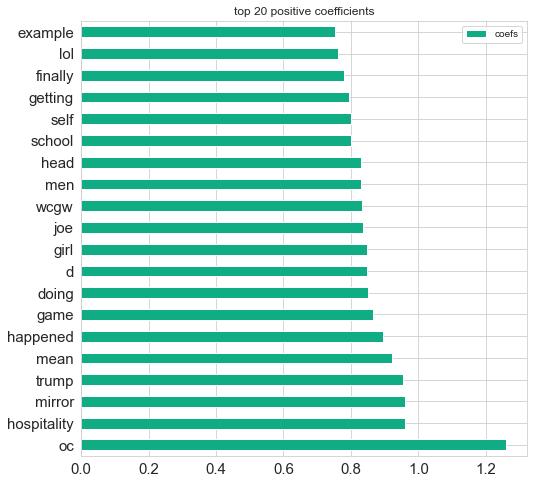

In [244]:
coef_df.sort_values(by='coefs', ascending=False).head(20).plot(kind='barh',
                                                                    title = 'top 20 positive coefficients',
                                                                    figsize=(8,8), fontsize=15, color='#10ac84');


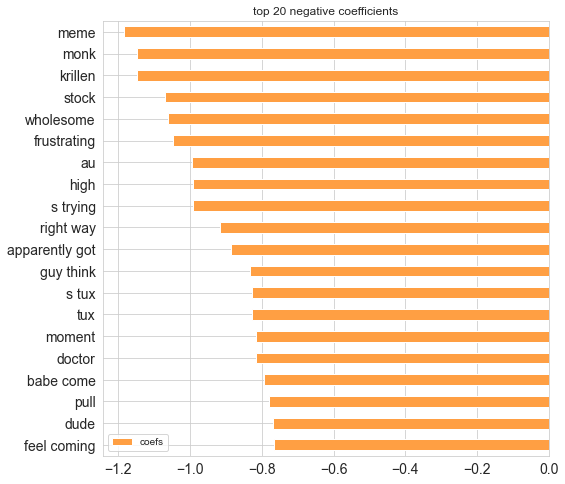

In [245]:
coef_df.sort_values(by='coefs', ascending=False).tail(20).plot(kind='barh',
                                                                      title= 'top 20 negative coefficients',
                                                                      figsize=(8,8), fontsize=14, color='#ff9f43');


In [246]:
logr_predictions = pipe.predict(X_test)

In [247]:
# Printing the classification report for logestic regression model:
print(classification_report(y_test, logr_predictions))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      1535
           1       0.84      0.74      0.79      1513

    accuracy                           0.80      3048
   macro avg       0.80      0.80      0.80      3048
weighted avg       0.80      0.80      0.80      3048



In [248]:
# Printing the classification report for Random Forest Classifier model:

print(classification_report(y_test, rfc_predictions))

              precision    recall  f1-score   support

           0       0.79      0.84      0.82      1535
           1       0.83      0.78      0.80      1513

    accuracy                           0.81      3048
   macro avg       0.81      0.81      0.81      3048
weighted avg       0.81      0.81      0.81      3048



## Interpretation:

- overall accuracy is `81%` which is better than the baseline score `50%` based on class majority

- For low engagement we have a good percision`77%` which is the true positive out of all positive observations,recall`87%` which is the true positive of all observations. and f1 score`82%` which is the harmonic mean between percision and recall.

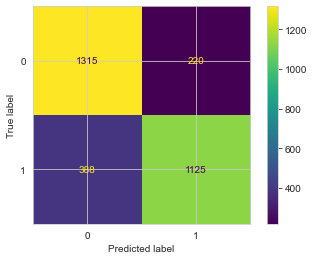

In [249]:
ConfusionMatrixDisplay.from_estimator(pipe,X_test, y_test);


In [250]:
print(confusion_matrix(y_test, pipe.predict(X_test)))

[[1315  220]
 [ 388 1125]]


## Interpretation:

- True positive: 1313
- True Negative: 1145
- False Negative: 222
- False Positive: 368

- The overall effectiveness of my model 
